# <center> Tarea Semanal 9 <center>
## <center> Autores: Arturo Huber y Matias Galperin <center>

### Introducción Teórica 

Durante el curso de la materia, vimos casi con exclusividad sistemas lineales. En este trabajo abordaremos el uso de sistemas no lineales para la estimación de línea de base del ECG. A diferencia de un sistema lineal, un sistema no lineal no cumple con las propiedades de aditividad y homogeneidad, por lo que: 
$$
f(x_1+x_2)\neq f(x_1)+f(x_2)
$$

$$
f(ax)\neq af(x)
$$

Los estimadores que usaremos en este trabajo son:

* Filtro de la mediana:

Estimaremos la linea de base del ECG $(\hat{b})$, a partir de la siguiente expresion:

$$
\hat{b} = \operatorname{med}_{600}\!\left( \operatorname{med}_{200}(ecg) \right)
$$

Este estimador aplica dos filtros de mediana consecutivos utilizando ventanas temporales de distinto tamaño. En la primera etapa se utiliza una ventana corta que atenúa las fluctuaciones rápidas de la señal, incluidas las variaciones bruscas asociadas a los complejos del ECG. Luego, sobre ese resultado, se aplica una segunda mediana con una ventana mucho mayor, capaz de suprimir las oscilaciones lentas como las provocadas por la respiración o los movimientos del paciente. La combinación de ambas etapas permite obtener una estimación sobre la línea de base de la señal. 

* Interpolación mediante splines cubicos:

Este estimador se basa en identificar puntos de la señal donde la actividad eléctrica es mínima e interpolarlos mediante splines cúbicos. Estos splines generan una curva que pasa por esos puntos y modela las variaciones lentas de la línea de base sin verse afectada por los picos rápidos del ECG. La elección de splines cúbicos se debe a que garantizan continuidad hasta la segunda derivada, lo que produce una línea de base suave. 

También, aplicaremos un filtro adaptado (matched filter) para la detección de latidos. Este filtro busca detectar un patrón conocido inmerso en ruido, entonces, si se conoce de antemano la forma temporal del evento que se quiere detectar —en este caso, el complejo QRS—, el filtro óptimo en el sentido de maximizar la SNR es aquel cuya respuesta impulsiva es la versión invertida en el tiempo del patrón buscado. De esta forma, el filtro opera como un correlador: cuando la señal de entrada contiene un segmento que coincide en forma con el patrón, la salida presenta un pico bien definido que facilita su detección. 

### Análisis y Desarrollo

In [1]:
from scipy.io import loadmat
from scipy.interpolate import CubicSpline
from scipy.signal import  find_peaks, butter, filtfilt
from scipy.ndimage import median_filter
from scipy.stats import median_abs_deviation
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Cargar ECG
data = loadmat('./ECG_TP4.mat')
ecg = np.array(data['ecg_lead']).flatten()
qrs_ref = np.array(data['qrs_detections']).flatten().astype(int)
qrs_pattern = np.array(data['qrs_pattern1']).flatten()

fs = 1000
t = np.arange(len(ecg)) / fs

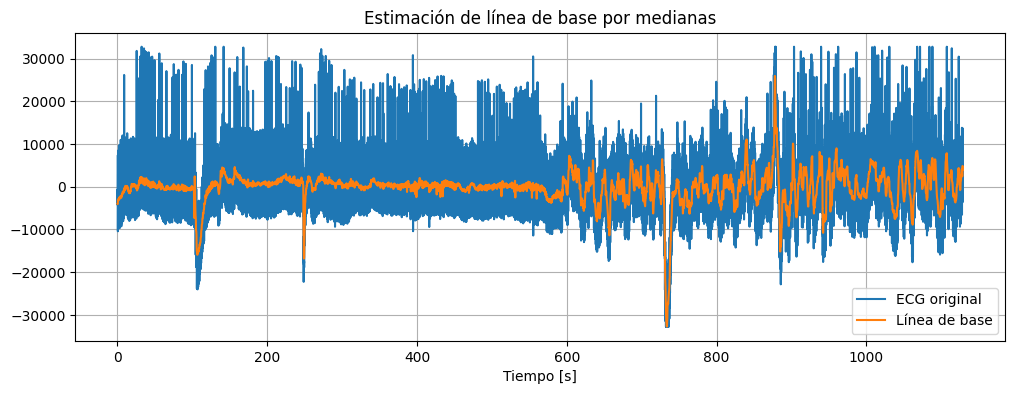

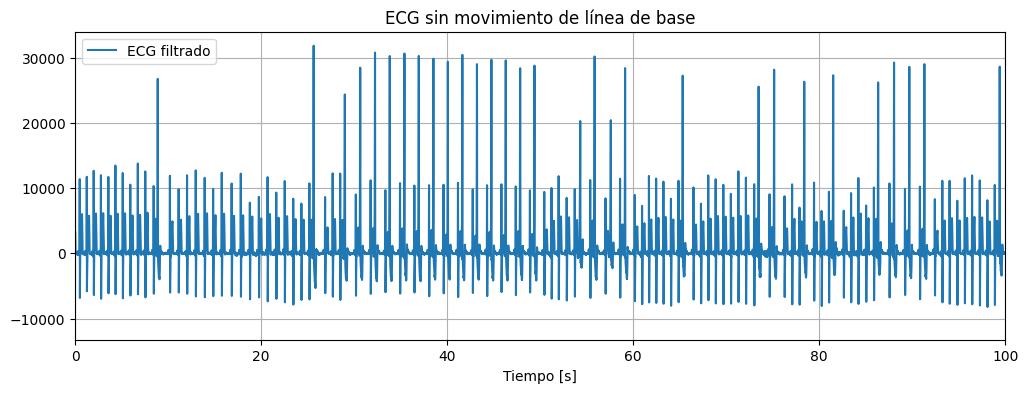

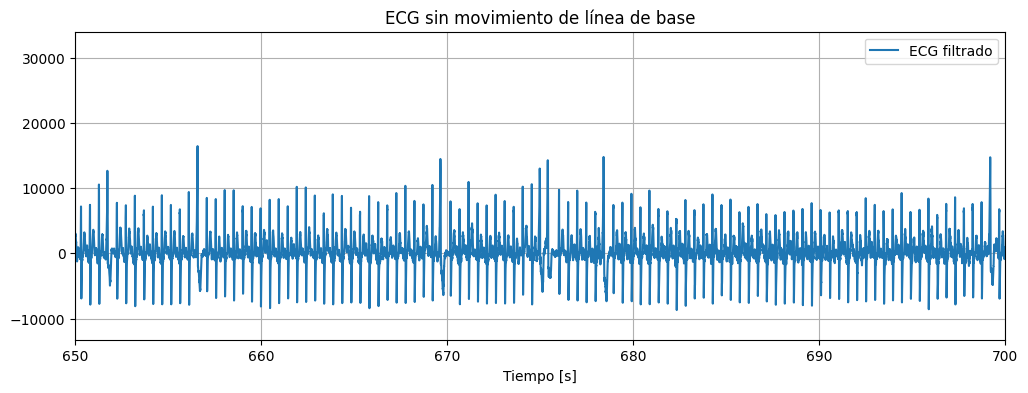

In [2]:
#%% Punto 1:

# Ventanas en muestras
T1 = int (0.200 * fs)   # 200 ms
T2 = int (0.600 * fs)   # 600 ms

# Aplicar mediana de 200 ms
b = median_filter(ecg, size=T1, mode='reflect')

# Aplicar mediana de 600 ms sobre el resultado
base = median_filter(b, size=T2, mode='reflect')

# ECG sin línea de base (método mediana)
ecg_filt = ecg - base

plt.figure(figsize=(12,4))
plt.plot(t, ecg, label='ECG original')
plt.plot(t, base, label='Línea de base')
#plt.xlim(0, 1000)
plt.legend()
plt.xlabel('Tiempo [s]')
plt.title('Estimación de línea de base por medianas')
plt.grid(True)
plt.show()

plt.figure(figsize=(12,4))
plt.plot( t, ecg_filt, label='ECG filtrado')
plt.xlim(0, 100)
plt.legend()
plt.xlabel('Tiempo [s]')
plt.title('ECG sin movimiento de línea de base')
plt.grid(True)
plt.show()

plt.figure(figsize=(12,4))
plt.plot( t, ecg_filt, label='ECG filtrado')
plt.xlim(650, 700)
plt.legend()
plt.xlabel('Tiempo [s]')
plt.title('ECG sin movimiento de línea de base')
plt.grid(True)
plt.show()


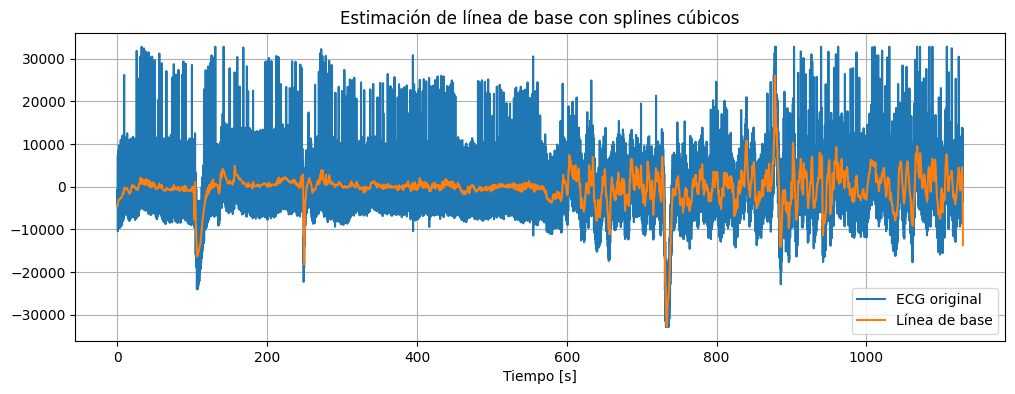

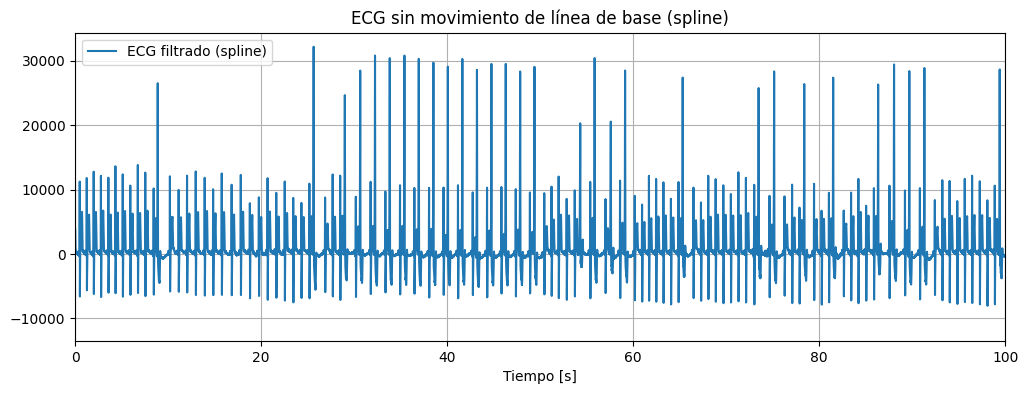

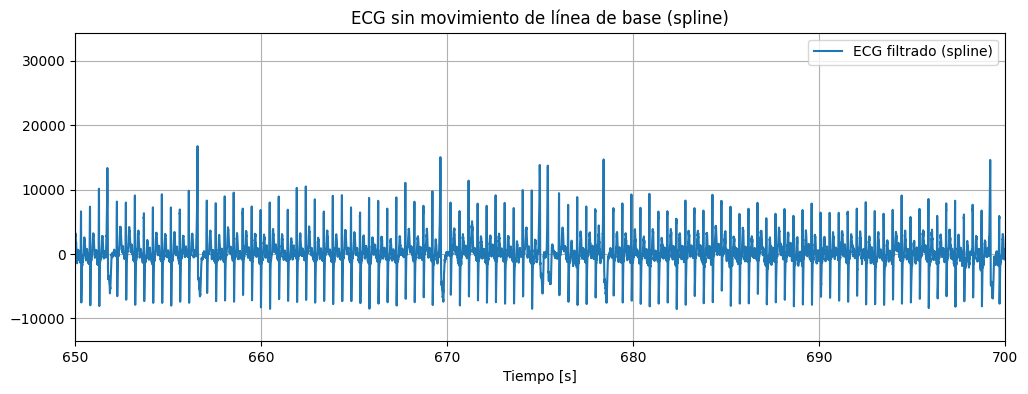

In [3]:
#%% Punto 2:
    
# Elegir n0 como adelanto respecto al QRS para caer en el segmento PQ
# (puede ser algo entre 80 y 150 ms, lo vas ajustando)
n0_ms = 120  # en ms
n0 = int(n0_ms * fs / 1000)  # pasar a muestras

# Evitar índices negativos
m = qrs_ref[qrs_ref > n0] - n0  
s_m = ecg[m]                    

# Interpolación spline cúbica
spline = CubicSpline(m, s_m)

n = np.arange(len(ecg))
base_spline = spline(n)

# ECG sin línea de base (método spline)
ecg_f_spline = ecg - base_spline

# Graficar comparación
plt.figure(figsize=(12,4))
plt.plot(t, ecg, label='ECG original')
plt.plot(t, base_spline, label='Línea de base')
plt.legend()
plt.xlabel('Tiempo [s]')
plt.title('Estimación de línea de base con splines cúbicos')
plt.grid(True)
plt.show()

plt.figure(figsize=(12,4))
plt.plot(t, ecg_f_spline, label='ECG filtrado (spline)')
plt.xlim(0, 100)
plt.legend()
plt.xlabel('Tiempo [s]')
plt.title('ECG sin movimiento de línea de base (spline)')
plt.grid(True)
plt.show()

plt.figure(figsize=(12,4))
plt.plot(t, ecg_f_spline, label='ECG filtrado (spline)')
plt.xlim(650, 700)
plt.legend()
plt.xlabel('Tiempo [s]')
plt.title('ECG sin movimiento de línea de base (spline)')
plt.grid(True)
plt.show()



In [4]:
#%% Punto 3:

def bandpass(x, fs, low=5, high=25, order=3):
    b, a = butter(order, [low/(fs/2), high/(fs/2)], btype='band')
    return filtfilt(b, a, x)

def compute_metrics(detected, reference, fs, tol_ms):
    """
    Computar metricas:
        Si coincide con un latido real dentro de la tolerancia -> True Positive
        Sino coincide con un latido real -> False Positive
        Diferencia entre latidos reales y TP -> False Negative
        
    """
    tol = int((tol_ms/1000) * fs)
    used = np.zeros(len(detected), dtype=bool)
    TP = 0
    FN = 0
    for q in reference:
        if len(detected) == 0:
            FN += 1
            continue
        dif = np.abs(detected - q)
        i = np.argmin(dif)
        if dif[i] <= tol:
            TP += 1
            used[i] = True
        else:
            FN += 1
    FP = np.sum(~used)
    sens = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    ppv  = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    return {"TP": TP, "FN": FN, "FP": int(FP), "sensitivity": sens, "ppv": ppv}

# Filtrar y normalizar ECG
ecg_f = bandpass(ecg, fs)
ecg_f = (ecg_f - np.mean(ecg_f)) / (np.std(ecg_f) + 1e-12)

# Normalizar el patron de referencia 
qrs_pattern = (qrs_pattern - np.mean(qrs_pattern)) / (np.std(qrs_pattern) + 1e-12)

# Inversion del patron y convolucion
h = qrs_pattern[::-1]
y = np.convolve(ecg_f, h, mode='same')

# Umbral de deteccion de los picos
thr = np.percentile(y, 90) + 3 * median_abs_deviation(y)

# Minima distancia entre picos
min_dist = int(0.25 * fs)

peaks, props = find_peaks(y, height=thr, distance=min_dist)
qrs_detected = peaks

metrics = compute_metrics(qrs_detected, qrs_ref, fs, tol_ms=25)

TP = metrics["TP"]
FN = metrics["FN"]
FP = metrics["FP"]
TN = 0  # No existe TN en detección de eventos

# Construir la matriz de confusión
conf_matrix = pd.DataFrame(
    [[f"{TP} (TP)", f"{FN} (FN)"],
     [f"{FP} (FP)", f"{TN} (TN)"]],
    index=["POSITIVO", "NEGATIVO"],
    columns=["POSITIVO", "NEGATIVO"]
)

print(f"Sensibilidad = {metrics['sensitivity']*100:.2f} %")
print(f"PPV = {metrics['ppv']*100:.2f} %")

display(conf_matrix)


Sensibilidad = 99.95 %
PPV = 99.79 %


,POSITIVO,NEGATIVO
POSITIVO,1902 (TP),1 (FN)
NEGATIVO,4 (FP),0 (TN)


### Conclusiones

En este trabajo se evaluaron dos enfoques para estimar la línea de base en registros de ECG y se utilizó un matched filter para la detección de latidos.

En cuanto a la estimación de la línea de base, al analizar el ECG luego de aplicar ambos métodos —la cascada de medianas y la interpolación mediante splines cúbicos— se observa que la señal resultante queda correctamente recentrada alrededor de cero. Esto indica que el movimiento de la línea de base fue eliminado de manera efectiva, suprimiendo las oscilaciones lentas y los desplazamientos globales presentes en el registro original.

En conjunto, los resultados muestran que ambas estrategias logran una corrección satisfactoria de la deriva, cada una con sus propias fortalezas: la simplicidad y robustez del filtrado por medianas, y la capacidad de modelado suave y específico del método de splines. Esto confirma que los dos enfoques son adecuados para la estimación de la línea de base en señales de ECG afectadas por movimientos lentos o artefactos de deriva.

En cuanto a la detección de latidos, el uso del filtro adaptado también produjo resultados muy buenos, alcanzando sensibilidad y PPV superiores al 99%. No obstante, es importante tener en cuenta que su rendimiento depende fuertemente de que el patrón elegido represente adecuadamente la variabilidad del QRS. Cambios morfológicos entre latidos, ruido muscular, artefactos o variabilidad inter-paciente pueden disminuir la correlación y generar falsos positivos o latidos no detectados.